In [1]:
import sys

import warnings
# warnings.filterwarnings('ignore')

from skmap.io import read_rasters, save_rasters #, RasterData
from skmap.io import process
from skmap.misc import date_range, ttprint , new_memmap # load_memmap, del_memmap, ref_memmap
# from eumap.misc import find_files, nan_percentile, ttprint
# from eumap.raster import read_rasters, save_rasters
import os

from pathlib import Path
from minio import Minio
# from eumap.misc import find_files, nan_percentile
import numpy as np
import gc
import numexpr as ne
import bottleneck as bn

from minio.commonconfig import REPLACE, CopySource
import time as tm
import multiprocess as mp
import geopandas as gpd
import matplotlib.pyplot as plt 
import fiona
from osgeo import gdal

bands = [('blue',1),('green',2),('red',3),('NIR',4),('SWIR1',5),('SWIR2',6),('thermal',7),('qa',8)]
tiles = ['005E_52N', '006E_51N', '023E_52N', '007E_46N'] #, '024E_38N', '004W_36N', '004E_51N',
# tiles = ['016E_63N','017E_63N','006W_53N','006W_52N','003E_52N','004E_52N','003E_51N','004E_51N','005E_52N','006E_52N','005E_51N',
#          '006E_51N','023E_52N','007E_46N','008E_46N','009E_44N','010E_44N','023E_38N','024E_38N','023E_37N','004W_36N']

gdal_opts = {
    'GDAL_HTTP_MULTIRANGE': 'YES',
    'GDAL_HTTP_MERGE_CONSECUTIVE_RANGES': 'YES',
    'GDAL_HTTP_VERSION': '1.0',
    'GDAL_DISABLE_READDIR_ON_OPEN': 'EMPTY_DIR',
    'VSI_CACHE': 'FALSE',
    'CPL_VSIL_CURL_ALLOWED_EXTENSIONS': '.tif',
    'GDAL_HTTP_CONNECTTIMEOUT': '320',
    'CPL_VSIL_CURL_USE_HEAD': 'NO',
    'GDAL_HTTP_TIMEOUT': '320',
    'CPL_CURL_GZIP': 'NO'
}

itvls = []
years = list(np.arange(2000,2022,1))
for year in years:
    for j in np.arange(1,24,1):
        itvls.append((year,(year-1980)*23+j))
        
ddoy = ['001','017','033','049','065','081','097','113','129','145','161','177','193','209','225','241','257','273','289','305','321','337','353']
dioy = list(range(1,24,1))
doy = dict(zip(dioy,ddoy))


filler = process.SeasConvFill(season_size = 23,att_seas = 60,att_env = 20,return_qa = True, n_jobs=40,verbose = True)
# urls = ard2_urls(tile, hosts = s3['hosts'], bucket=s3['bucket_r'], itvls = itvls)
# rdata = read_rasters(raster_files=urls, band=band[1], dtype='uint16', n_jobs=50, expected_shape=(4004,4004), verbose=True)

In [2]:
# def ard2_urls(tile, hosts, bucket, itvls):
#   urls = []
#   ih = 0
  
#   for y,d in itvls:
#         host = hosts[ih]
#         urls.append(f'http://{host}/{bucket}/{y}/{tile}/{d}.tif')
#         ih += 1
#         if ih >= len(hosts):
#             ih = 0
            
#   return urls

# # Primus URL
# # 'hosts': [ f'192.168.1.{i}:8333' for i in range(30, 39) ],

# s3 = {
#   'hosts': [ f'192.168.49.{i}:8333' for i in range(30, 39) ],
#   'access_key': 'iwum9G1fEQ920lYV4ol9',
#   'secret_key': 'GMBME3Wsm8S7mBXw3U4CNWurkzWMqGZ0n2rXHggS0',
#   'secure': False,
#   'bucket_r': 'landsat-ard2',
#   'bucket_w': 'landsat-ard2',
#   'prefix': 'hconv'
# }

def ard2_urls(tile,itvls):
    urls = []
    for y,d in itvls:
        urls.append(f'/mnt/apollo/bare_soil_xuemeng/tmp_files/original/{tile}/{d}.tif')
    return urls

def clearsky(urls):
    # ttprint("Reading mask") 
    rdata = read_rasters(raster_files=urls, band=8, dtype='uint8', n_jobs=40, expected_shape=(4004,4004), verbose=True, gdal_opts=gdal_opts)
    ttprint("Reading mask finished")
    
    ttprint("Deriving clear_sky_mask")
    clear_sky_mask = new_memmap('uint8', rdata.shape)
    clear_sky_mask[:] = ne.evaluate("((rdata >= 1) & (rdata <= 2)) | ((rdata >= 5) & (rdata <= 6)) | ((rdata >= 11) & (rdata <= 17))")
    clear_sky_mask.flush()
    return clear_sky_mask

def block_gapfill(rdata):
    ttprint(f'block gapfilling')
    result = np.empty(rdata.shape, dtype=np.float32)  # Adjust dtype as needed
    qab = np.empty(rdata.shape, dtype=np.float32)  # Adjust dtype as needed
    block_size = (2002,2002,rdata.shape[2])
    
    for i in range(0, rdata.shape[0], block_size[0]):
        for j in range(0, rdata.shape[1], block_size[1]):
            block_slice = (slice(i, i + block_size[0]), slice(j, j + block_size[1]))
            block = rdata[block_slice]
            # print(block_slice)
            
            gp, qa = filler._gapfill(block)
            result[block_slice[0], block_slice[1], :] = gp
            qab[block_slice[0], block_slice[1], :] = qa
            
    ttprint(f'finish computing, data shape:{result.shape}')
    return result, qa


def gapfill(tile):
    # urls = ard2_urls(tile, hosts = s3['hosts'], bucket=s3['bucket_r'], itvls = itvls)
    urls = ard2_urls(tile,itvls)
    print(urls[0])
    clear_sky_mask = clearsky(urls)
    prefix = '/mnt/apollo/bare_soil_xuemeng/tmp_files'
    tile = tile.replace('_','.')
    
    for band in bands[-3:-2]:
        ttprint(f'reading {urls[0]}, {band[0]}')
        
        outfiles = [prefix + f'/gapfilled/{tile}/landsat_gapfilled_{band[0]}_{tile}_{i[0]}{doy.get(i[1]-(i[0]-1980)*23)}.tif' for i in itvls]
        qa_outfiles = [prefix + f'/gapfilled_qa/{tile}/landsat_gapfilled.qa_{band[0]}_{tile}_{i[0]}{doy.get(i[1]-(i[0]-1980)*23)}.tif' for i in itvls]
        folder_path = prefix + f'/gapfilled/{tile}'
        if os.path.exists(folder_path):
            check = [filename for filename in os.listdir(folder_path) if f'{band}' in filename]
            if len(check)==506:
                ttprint(f'{tile}, {band} already exist')
                continue
        
        rdata = read_rasters(raster_files=urls, band=band[1], dtype='float32', n_jobs=40, expected_shape=(4004,4004), verbose=True, gdal_opts=gdal_opts) # read in as float32
        rdata[:] = ne.evaluate('where(clear_sky_mask == 1, rdata,  na)', local_dict={'rdata': rdata, 'clear_sky_mask': clear_sky_mask, 'na': np.nan})
        result, qa = block_gapfill(rdata)
        try:
            save_rasters(base_raster=urls[0], raster_files=outfiles, data=result, dtype='uint16', n_jobs=30)
            # save_rasters(base_raster=urls[0], raster_files=qa_outfiles, data=qa, dtype='uint16', n_jobs=50)
        except:
            import pdb
            pdb.set_trace()
        ttprint(f'finish writing')
        
    ttprint(f'{tile} done!')
    print()
    return None

In [1]:

import shutil

for tile in ['007E_46N']:
    # gapfill(tile)
    shutil.rmtree(f'/mnt/apollo/bare_soil_xuemeng/tmp_files/original/{tile}')



In [ ]:
folder_path = f'/mnt/primus/xuemeng_tmp_harbour/crop_bare_index/tmp_files/gapfilled/{tile}'
files = [filename for filename in os.listdir(folder_path) if f'{band}' in filename]

In [12]:
def move(tile):
    import subprocess
    
    src = f'/mnt/apollo/bare_soil_xuemeng/tmp_files/gapfilled/{tile}/'
    tgt = f'gaia/tmp-bare-soil/16days/{tile}/'  #http://192.168.1.30:8333
    command = f'mc cp --recursive {src} {tgt}'
    print(command)
    # result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    # return result

move(tiles[2].replace('_','.'))

mc cp --recursive /mnt/apollo/bare_soil_xuemeng/tmp_files/gapfilled/006W.53N/ gaia/tmp-bare-soil/16days/006W.53N/


In [ ]:
/017E.63N/landsat_gapfilled_SWIR2_017E.63N_2021193.tif

In [46]:
itvl = itvls[0]
inputs = [f'http://192.168.1.30:8333/landsat-ard2/{itvl[0]}/{tile}/{itvl[1]}.tif' for tile in tiles]
output = f'/mnt/primus/xuemeng_tmp_harbour/crop_bare_index/tmp_files/vrt/landsat_{itvl[0]}{doy.get(itvl[1]-(itvl[0]-1980)*23)}.vrt'

vrt_options = gdal.BuildVRTOptions(resampleAlg='cubic', addAlpha=True)
a = gdal.BuildVRT(output, inputs, options = vrt_options)
# a.FlushCache()
print(a)

None


In [52]:
# # old version applied on files with right names

# def worker_gapfill(ts,bs,period):
    
#     if period == 'monthly':
#         ks = 1
#         out_f = f'/mnt/tupi/Xuemeng_testing/{period}_gapfilled/landsat_{bs}_{ts}_2021335.tif'
#     else:
#         ks = 2
#         out_f = f'/mnt/tupi/Xuemeng_testing/{period}_gapfilled/landsat_{bs}_{ts}_2021305.tif'
        
#     print(out_f)
#     if os.path.exists(out_f):
#         print(f'{period}_{bs}_{ts} exists!')
#         return None
#     else:
#         print(f'{period}_{bs}_{ts} generating...')
    
#     group = {f'{bs}': f'http://192.168.1.30:8333/tmp-bare-soil/landsat_{period}/{bs}_landsat.{ts}_p50_'+'{dt}.tif'}
    
        
#     rdata = RasterData(group,verbose=True) \
#     .timespan('2000001', '2021336', date_step=23, date_unit='days', date_format='%Y%j', date_style='start_date', ignore_29feb=True) \
#     .read()
    
#     outn = 'landsat_{gr}_'+f'{ts}' + '_{dt}'
#     base_raster_path = rdata._base_raster()
#     rdata = rdata.run(process.SeasConvFill(season_size=1), outname=outn, drop_input=True).rename(groups= {'{gr}..p50': '{gr}'})
#     rdata.info['input_path'] = base_raster_path
#     rdata.to_dir(f'{period}_gapfilled')
    
#     return None

# inputs = []
# for period in ['monthly']:
#     for bs in bands:
#         for ts in tile_ids:
#             inputs.append((ts,bs,period))
            
# # with mp.Pool(processes=3) as pool:
# #     result = pool.starmap(worker_gapfill, inputs)

# for i in inputs:
#     # print(i)
#     worker_gapfill(i[0],i[1],i[2])

In [42]:
# # examples from Leandro
# from skmap.data import toy
# from skmap.io import process

# # Loading NDVI quarterly time-series with gaps
# toy.ndvi_rdata(gappy=True 
#     # Gapfilling time-series by seasonal convolution 
#     ).run(process.SeasConvFill(season_size=4), drop_input=True
#     # Smoothing time-series by Whittaker
#     ).run(process.WhittakerSmooth(), group='ndvi.seasconv', drop_input=True
#     # Setting smoothed time-series as main input
#     ).rename(groups={'ndvi.seasconv.whittaker': 'ndvi'}
#     # Running yearly aggregation by std. and percentile 50th
#     ).run(process.TimeAggregate(time=[process.TimeEnum.YEARLY], operations = ['p50', 'std']), group=['ndvi']
#     # Running trend analysis using per-pixel linear regression  
#     ).run(process.TrendAnalysis(season_size=4), group='ndvi'
#     # Ploting all raster data
#     ).plot(v_minmax=[0,100])

In [18]:
# # # get the landsat tile ids that overlay with the fid chosen by Martijn
# eu = gpd.read_file('/mnt/primus/xuemeng_tmp_harbour/crop_bare_index/eu_tilling_system_30km.gpkg') #http://192.168.1.30:8333/tmp-bare-soil/eu_tilling_system_30km.gpkg
# landsat = gpd.read_file('/mnt/primus/xuemeng_tmp_harbour/crop_bare_index/glad_landsat_tiles.gpkg')

# # get fid id of tiles chosen by Martijn 
# with fiona.open('/mnt/primus/xuemeng_tmp_harbour/crop_bare_index/eu_tilling_system_30km.gpkg') as f:
#     feats = list(f)
#     fids = [f['id'] for f in feats]
# eu['id'] = fids
# eu['id'] = eu['id'].astype(int)

# eu_tile = [22497,16057,14576,14580,15560,10636,9326,9629,5606,4582]
# euc = eu[eu['id'].isin(eu_tile)]

# euc = euc.to_crs(epsg=4326)
# lap = gpd.sjoin(landsat, euc, how="inner", op="intersects")
# lap.to_file('/mnt/primus/xuemeng_tmp_harbour/crop_bare_index/overlay_10_test_tiles.gpkg', driver='GPKG')
# euc.to_file('/mnt/primus/xuemeng_tmp_harbour/crop_bare_index/eu_10_test_tiles.gpkg', driver='GPKG')
# # result['TILE'].values.tolist()

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


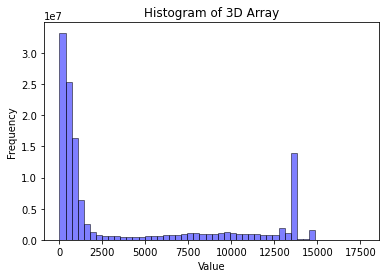

In [42]:

# hist, bins = np.histogram(rdata.flatten(), bins=50)  # Adjust the number of bins as needed
# plt.hist(rdata.flatten(), bins=50, alpha=0.5, color='b', edgecolor='black')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Histogram')
# plt.show()